# Network weight analysis

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiment import Experiment
from utils import print_stats
from scipy.stats import pearsonr, linregress


data_path = "../data"
save_path = "../figs"

In [2]:
exp = Experiment.load_experiment(data_path, 'baseline')

In [ ]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [3]:
net = exp.agent.actor
net.clamp_weights()

print("Bias stats:")
print_stats(net.b1)
print("\nWeight stats:")
print_stats(net.w1)
print("\nAggregated weight stats:")
print_stats(net.w1.sum(1))

Bias stats:
min   |max  |mean |std  |shape
-0.412|0.407|0.044|0.188|torch.Size([128])

Weight stats:
min   |max  |mean |std  |shape
0.000|11.255|0.994|0.963|torch.Size([128, 1000])

Aggregated weight stats:
min   |max  |mean |std  |shape
936.681|1097.668|994.358|48.996|torch.Size([128])


### L1 regularization effect

In [4]:
l1s = [f'l1_{n}' for n in ['01', '001', '0001', '00001', '000001', '0']]
l1s.insert(3, 'baseline')

In [5]:
means, stds = list(), list()
for l1 in l1s:
    exp = Experiment.load_experiment(data_path, l1)
    net = exp.agent.actor
    net.clamp_weights()
    
    nonzeros = (net.w1.data > 0.001).sum(-1)
    mean = nonzeros.mean(dtype=float).cpu().item()
    std = nonzeros.to(torch.float32).std(0).cpu().item()
    
    means.append(mean)
    stds.append(std)
    
    print(f"{l1}:\n  {mean:.03f} ± {std:.03f}")
    print()

l1_01:
  391.414 ± 39.114

l1_001:
  897.500 ± 28.619

l1_0001:
  964.023 ± 25.256

baseline:
  938.609 ± 23.952

l1_00001:
  968.766 ± 23.540

l1_000001:
  971.570 ± 22.051

l1_0:
  971.445 ± 21.661



In [6]:
l1s = [0.1, 0.01, 0.001, 0.0005, 0.0001, 0.00001, 0]

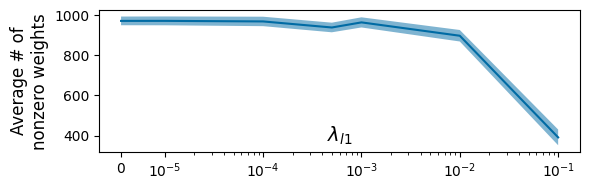

In [7]:
plt.figure(figsize=(6, 2))
plt.semilogx(l1s, means)
plt.fill_between(l1s, np.asarray(means) - stds, np.asarray(means) + stds, alpha=0.5)
plt.xscale('symlog', linthresh=1e-5, linscale=0.4, subs=range(2, 10))
plt.xlabel("$\\lambda_{l1}$", fontsize=14, labelpad=-40)
plt.ylabel("Average # of\nnonzero weights", fontsize=12)
plt.tight_layout()
plt.savefig("../figs/nonzero.png")
plt.show()

### Firing rate correlation

In [8]:
exp = Experiment.load_experiment(data_path, 'baseline')
net = exp.agent.actor
net.clamp_weights()

In [9]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [10]:
idx = exp.pfs.get_place_cells().cpu()

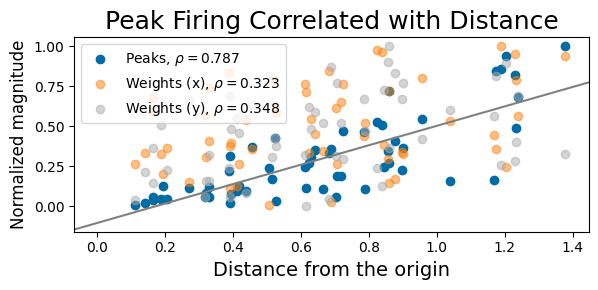

In [13]:
dists = exp.pfs.means[idx].detach().pow(2).sum(-1).cpu()#.tile(2)
scales = exp.pfs.scales[idx].pow(2).detach().cpu()
w_x, w_y = net.lin2.weight.detach().abs().cpu()[2:,idx]

slope, intercept, rho, *_ = linregress(dists, scales.squeeze()/scales.max(), alternative='greater')

plt.figure(figsize=(6, 3))
plt.scatter(dists, scales/scales.max(), label=f'Peaks, $\\rho={rho:.03}$')
plt.scatter(dists, w_x/w_x.max(), label=f'Weights (x), $\\rho={pearsonr(w_x, dists).statistic:.03}$', alpha=0.5)
plt.scatter(dists, w_y/w_y.max(), label=f'Weights (y), $\\rho={pearsonr(w_y, dists).statistic:.03}$', alpha=0.5)
plt.axline([0, intercept], slope=slope, c='gray')
plt.xlabel("Distance from the origin", fontsize=14)
plt.ylabel("Normalized magnitude", fontsize=12)
plt.title("Peak Firing Correlated with Distance", fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig("../figs/dist_corr.png")
plt.show()